## Computing Virtual Cones for case of sphere 

### Objective
Given spherical surface , set of camera rays and camera points, find virtual cones for each camera ray in parallel.

Starting with including required packaged and adding some helper functions

In [24]:
%matplotlib widget
import torch
from torch import autograd
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('.')
from utils.viz_util import (plot3d_arrow, plot3d_sphere, 
                            plot3d_point, plot3d_cone)

dot = lambda x,y: (x*y).sum(-1, keepdim=True)
norm = lambda x: torch.sqrt((x**2).sum(-1, keepdim=True))
transp = lambda x: x.transpose(-2,-1)
normalize = lambda x: x/(1e-7+norm(x))
to_np = lambda x: x[0,0].detach().cpu().numpy()

### Given quantities

$N$: Number of primary rays

$P$: Number of intersection points per primary ray

$\mathbf{o}$: Primary ray origin ($N \times P \times 3$)

$\mathbf{d}$: Primary ray direction ($N\times P \times 3$)

$t$: Distance along ray for intersection points($N\times P \times 1$) 

$r$: Radius of primary cone ($N \times P \times 3$)

$\mathbf{n}$: Surface normals at intersection normals ($N \times P \times 3$) 

$R$: Radius of curvature at the surface ($N \times P \times 3$)


Defining one primary ray,then repeating it to $N\times P$ values to test out the performance of this module in ORCa. Overall code should work with $N$ different primary rays

In [25]:
N = 128
P = 192

expand_NP = lambda x: x[None,None].expand(N,P,-1)

# Example visualization
o = expand_NP(torch.cuda.FloatTensor([3.,0.,0.])) # (N,P,3)
d = expand_NP(normalize(torch.cuda.FloatTensor([-1,0.2,0]))) # (N,P,3)
r = expand_NP(torch.cuda.FloatTensor([0.05])) # (N,P,1)
up = expand_NP(torch.cuda.FloatTensor([0.,1.,0]))# Up vector of camera Useful for cone rays

Here we obtain $t$ value from ray sphere intersection. But in ORCa pipeline, SDFNet would give us t values. Here consider center $c$ and radius of sphere $R$ are known. In ORCa, center won't be needed and radius can be computed from SDF.

In [26]:
def intersect_ray_sphere(o, d, c, R):
    # Sphere given by <x-c,x-c>=R**2
    # Ray given by x = o+td
    # Point of intersection t follows:
    # a2t^2 + a1t + a0 with following values
    a2 = 1.
    a1 = 2*dot(d, o-c)
    a0 = norm(o-c)**2 - R**2
    # Using quadratic formula finding the smaller of the two roots
    t_int = (-a1 - torch.sqrt(a1**2 - 4*a2*a0))/(2*a2)

    return o+t_int*d


R = expand_NP(torch.cuda.FloatTensor([1.])) # (N,P,1)
c = expand_NP(torch.cuda.FloatTensor([0., 0., 0.])) # (N,P,3)

p = intersect_ray_sphere(o,d,c,R)
# t is distance along ray
t = norm(p-o) # (N,P,1)
# surface normal points outwards from center
n = normalize(p-c) # (N, P, 3)

Here we visualize the known quantities. As all the $N \times P$ values are the same we just visualize the first one. 

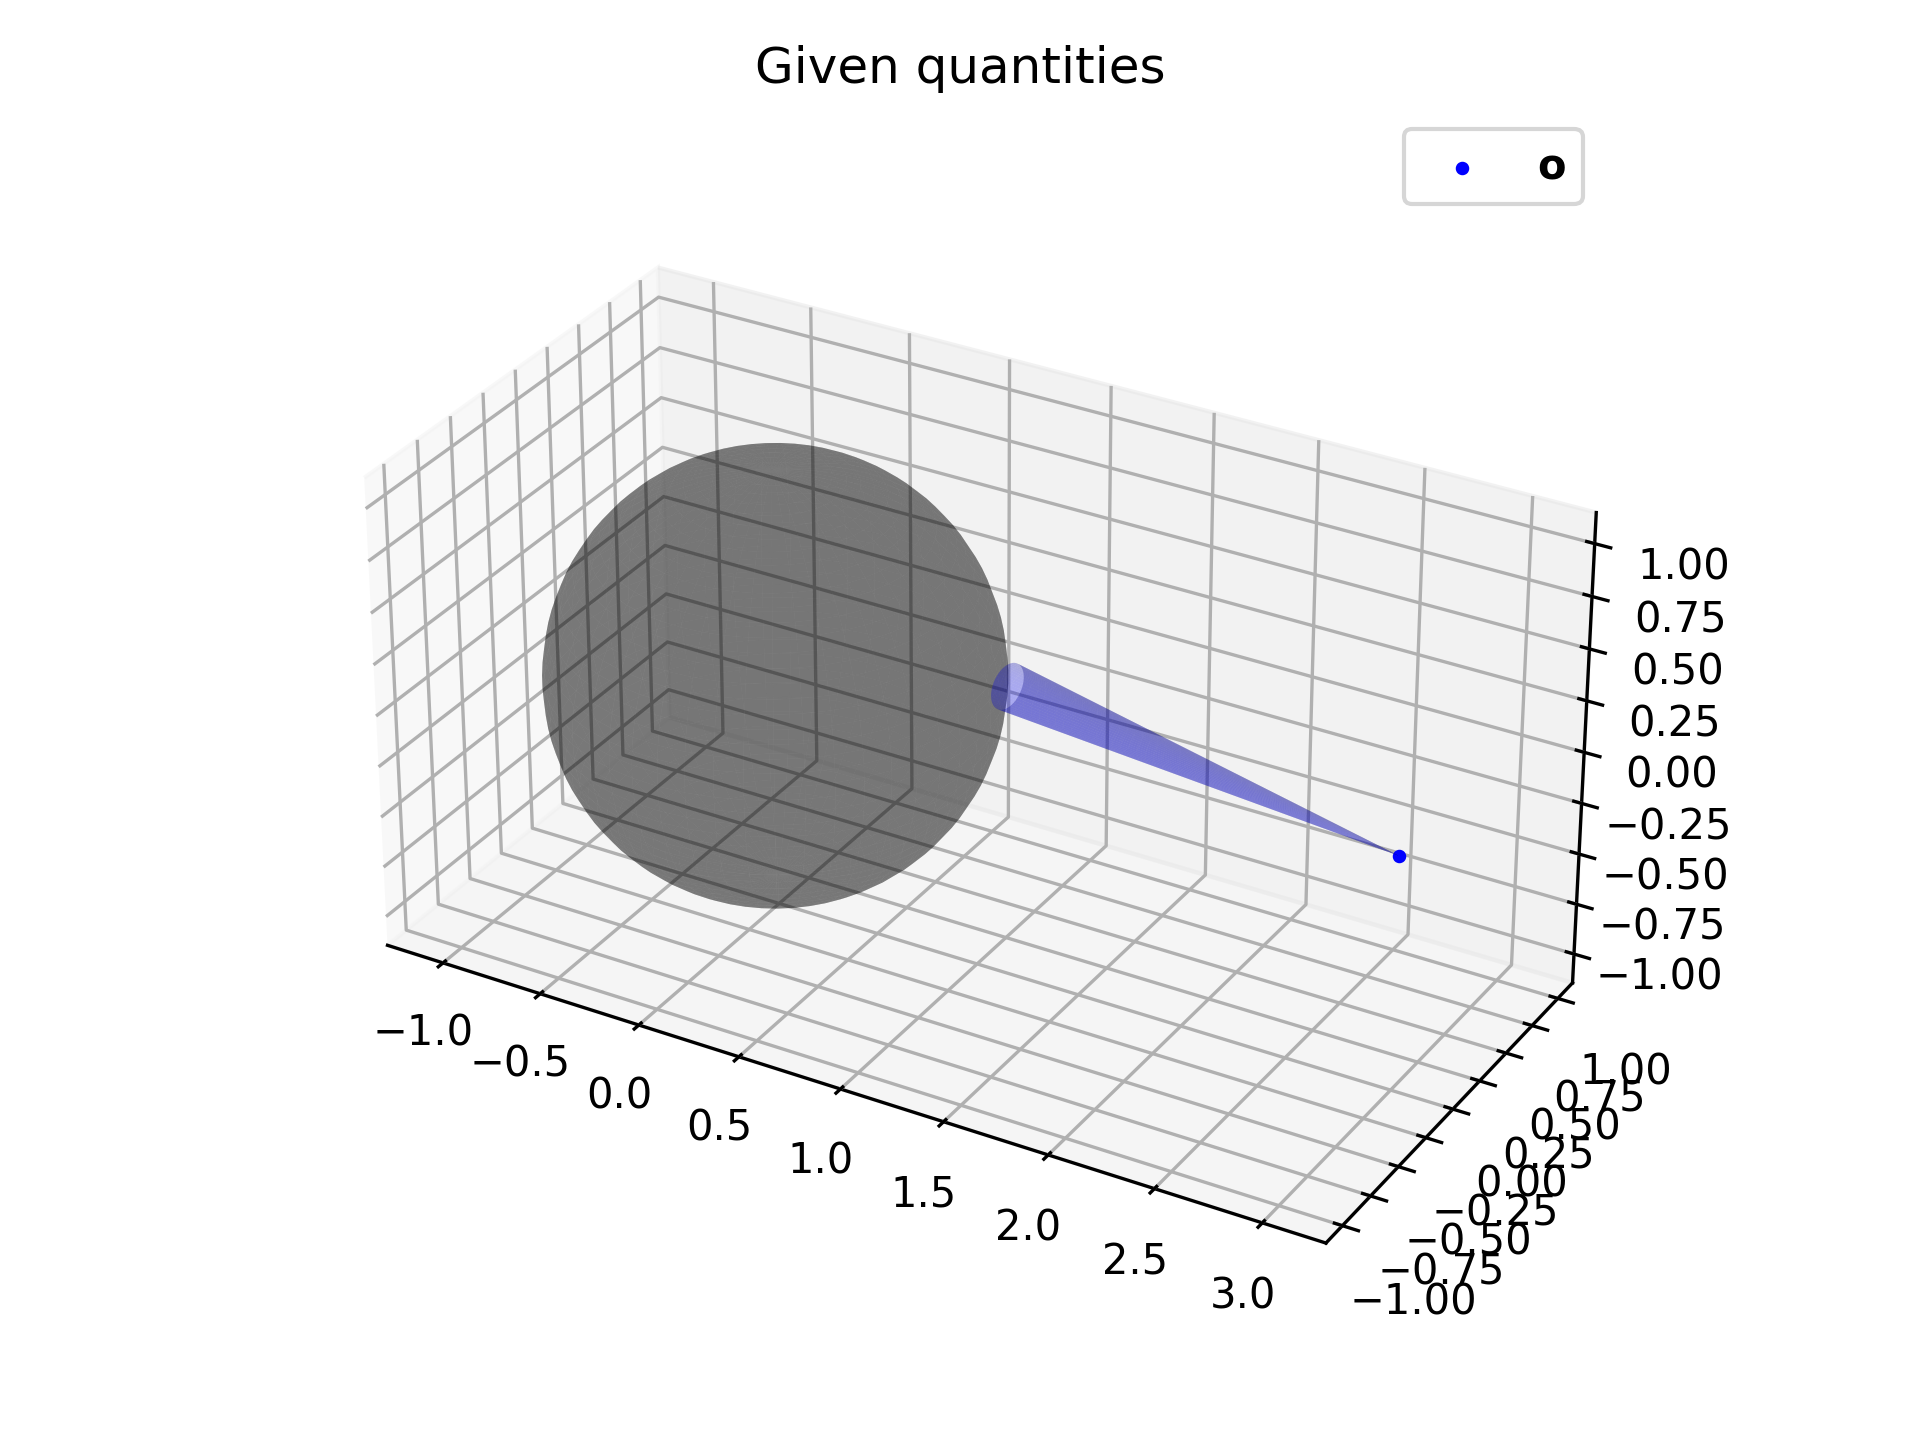

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((2,1,1))

plot3d_sphere(ax, to_np(R), to_np(c))
# plot3d_arrow(ax, to_np(o), to_np(t), to_np(d))
plot3d_point(ax, to_np(o), label='$\mathbf{o}$')
# plot3d_point(ax, to_np(o+t*d), label='$\mathbf{p}$')
plot3d_cone(ax, to_np(o), to_np(t), to_np(d), to_np(r))

plt.title('Given quantities')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Compute primary cone rays



For the primary cone per pixel, $\mathbf{o}$ is the apex, $\mathbf{d}$ is the axis and $r$ is the radius. Thus we can define the equation of the cone. In a plane $(u,v)$, perpedicular to the axis $\mathbf{d}$, the cone is a circle with radius $rt$. We sample this circle at four points with $\theta = \left[0, \pi/2, \pi, 3\pi/2 \right]$ to get 4 primary cone rays 

In [28]:
def get_uv(N,up):
    u = normalize(torch.cross(N,up))
    v = normalize(torch.cross(N,u))
    return u, v

def get_primary_cone_rays(o, t, d, r, up):
    thetas = torch.Tensor([0.,np.pi/2,np.pi,3*np.pi/2])\
                [None,None,:,None]\
                .to(t.device)
    u,v = get_uv(d,up)
    p_u = r*t*torch.cos(thetas)
    p_v = r*t*torch.sin(thetas)
    p_d = t
    p_cone = o+(p_u*u + p_v*v + p_d*d)
    d_cone = normalize(p_cone-o)
    t_cone = norm(p_cone-o)
    return d_cone,t_cone

# Add singleton dimensions to given quantities for cone rays
add_sing = lambda x: x[:,:,None,:]
o_s  = add_sing(o) # NxP x1x3
d_s  = add_sing(d) # NxP x1x3
r_s  = add_sing(r) # NxP x1x3
up_s = add_sing(up) # NxP x1x3
R_s = add_sing(R) # NxP x1x3
t_s = add_sing(t) # NxP x1x3
n_s = add_sing(n) # NxP x 1 x3

d_cone,t_cone = get_primary_cone_rays(o_s,t_s,d_s,r_s,up_s)


Intersection of primary cone rays and oscullating sphere

In [29]:
#Intersection point
p_s = o_s + t_s*d_s
#Find the center of osculating sphere by backtracing surface normal till R
c_est = p_s - R_s*n_s

p_int = intersect_ray_sphere(o_s,d_cone,c_est,R_s)
t_int = norm(p_int-o_s)
# nan_mask corresponding to rays that do not intersect
nan_mask = torch.isnan(t_int)

Append the primary ray point also to the cone rays 

In [30]:
p_int = torch.cat([p_int, p_s],-2)
t_int = torch.cat([t_int,t_s],-2)
d_cone = torch.cat([d_cone, d_s],-2)
# Primary intersection is always valid
nan_mask = torch.cat([nan_mask, 
                      torch.zeros_like(nan_mask[:,:,[0]])],-2)

/code/two_bounce_polar/utils/viz_util.py:25: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


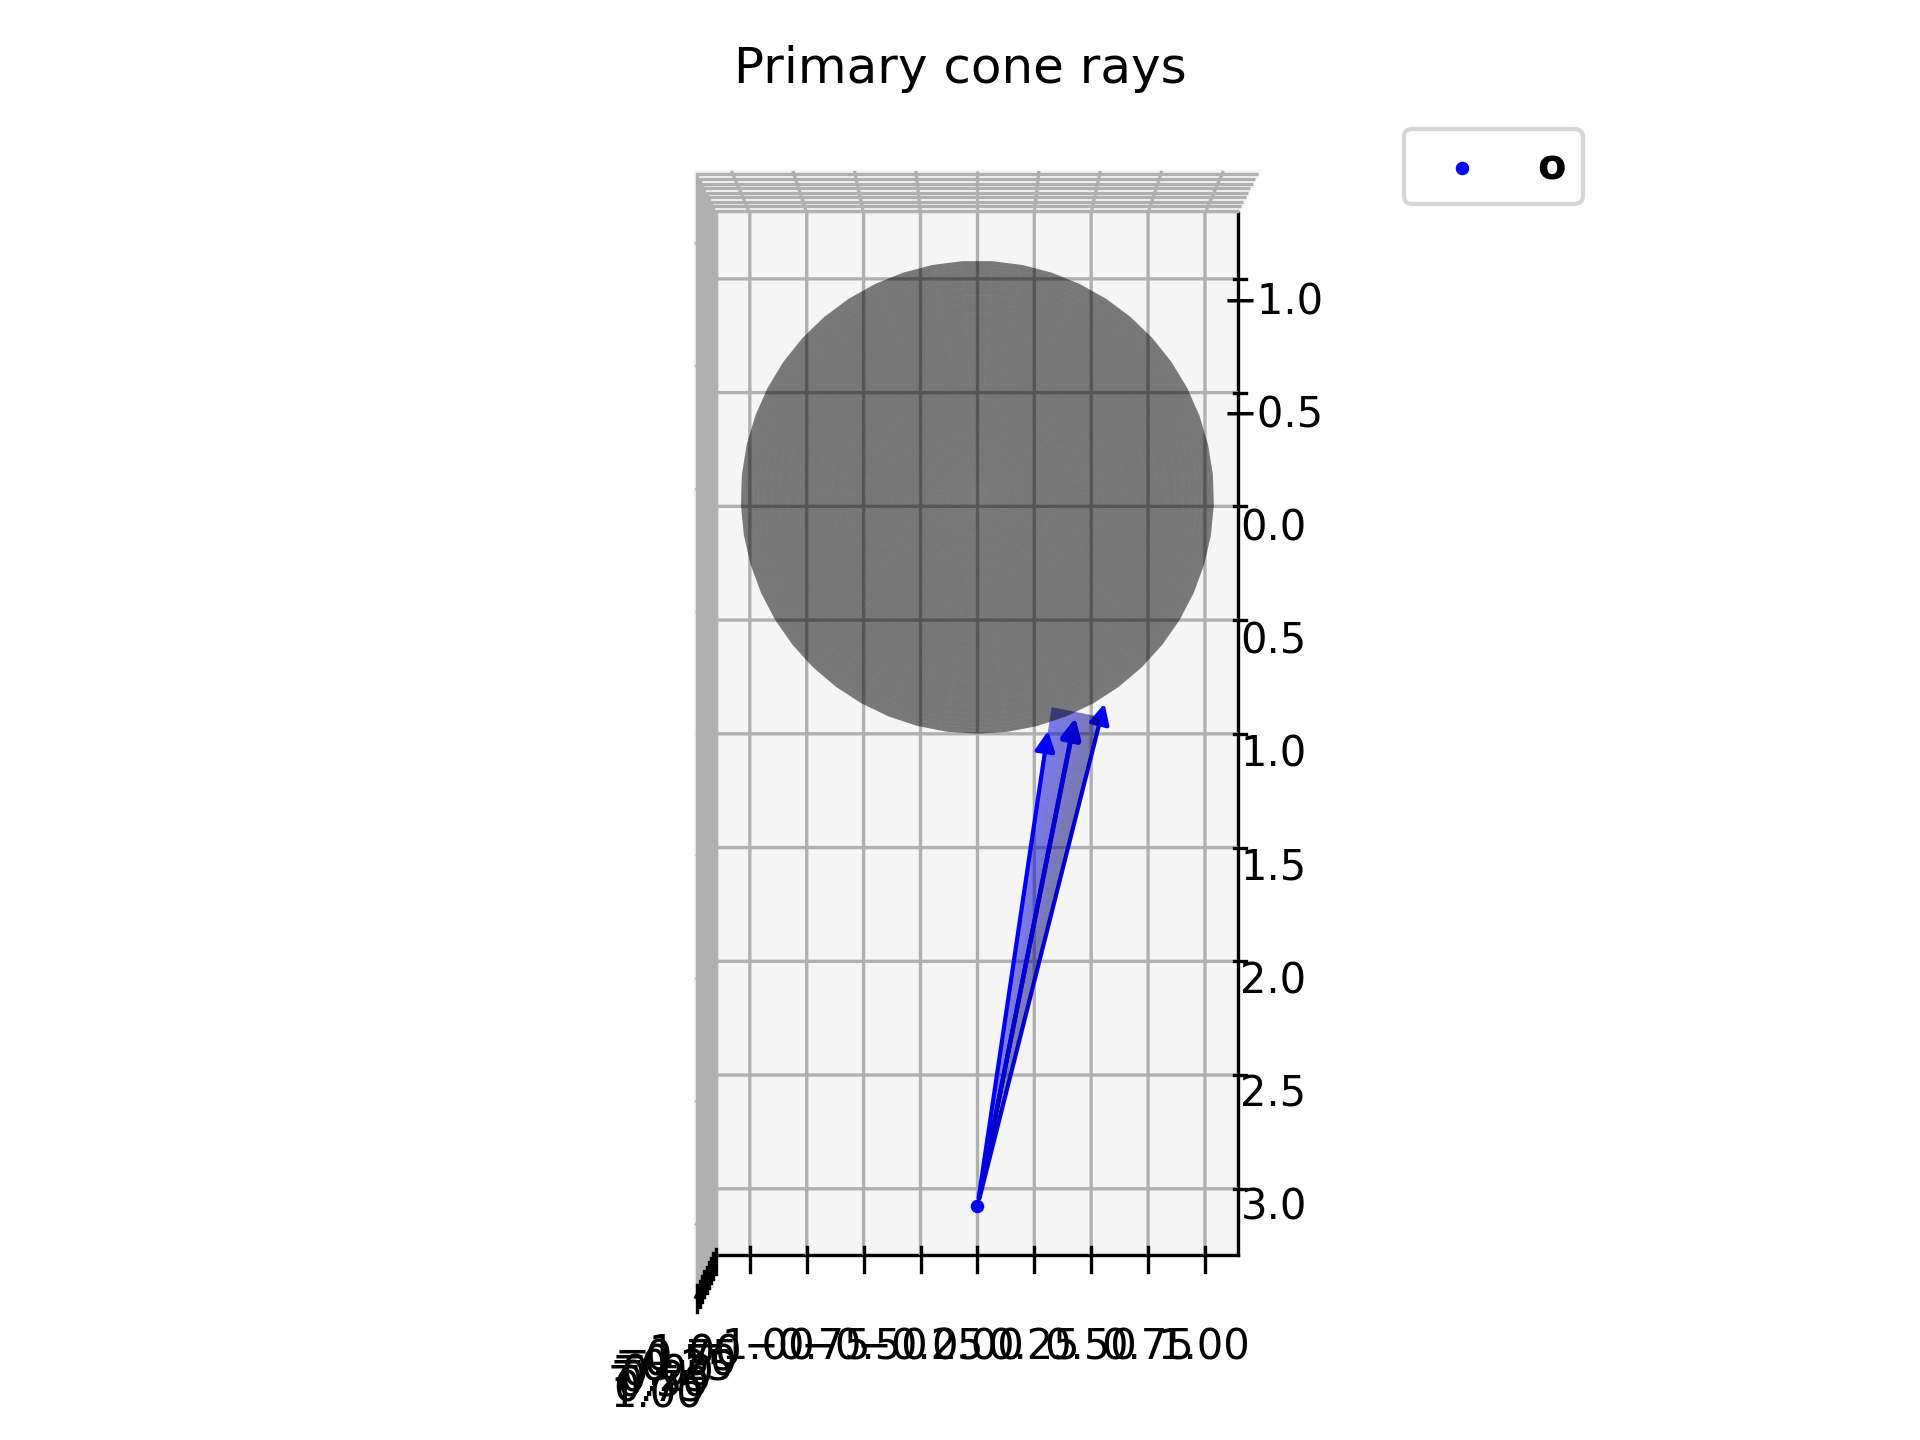

In [31]:
for cone_ray_idx in range(5):
    isnan = torch.isnan(t_int[:,:,cone_ray_idx]).sum()
    if isnan == 0:
        # plot3d_point(ax,to_np(p_int)[cone_ray_idx])
        plot3d_arrow(ax, to_np(o), 
                    to_np(t_int)[cone_ray_idx], 
                    to_np(d_cone)[cone_ray_idx],
                    color='b',
                    label='Primary cone rays')
ax.azim=0
ax.elev = 90
plt.title("Primary cone rays")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Compute reflected cone rays

First we estimate normals at each intersection point $\mathbf{n_{int}}$ with the oscullating sphere. Then use reflection formula to get the reflected rays $\mathbf{d_r}$.

In [32]:
n_int = normalize(p_int-c_est)
d_r = d_cone - 2*dot(d_cone, n_int)*n_int

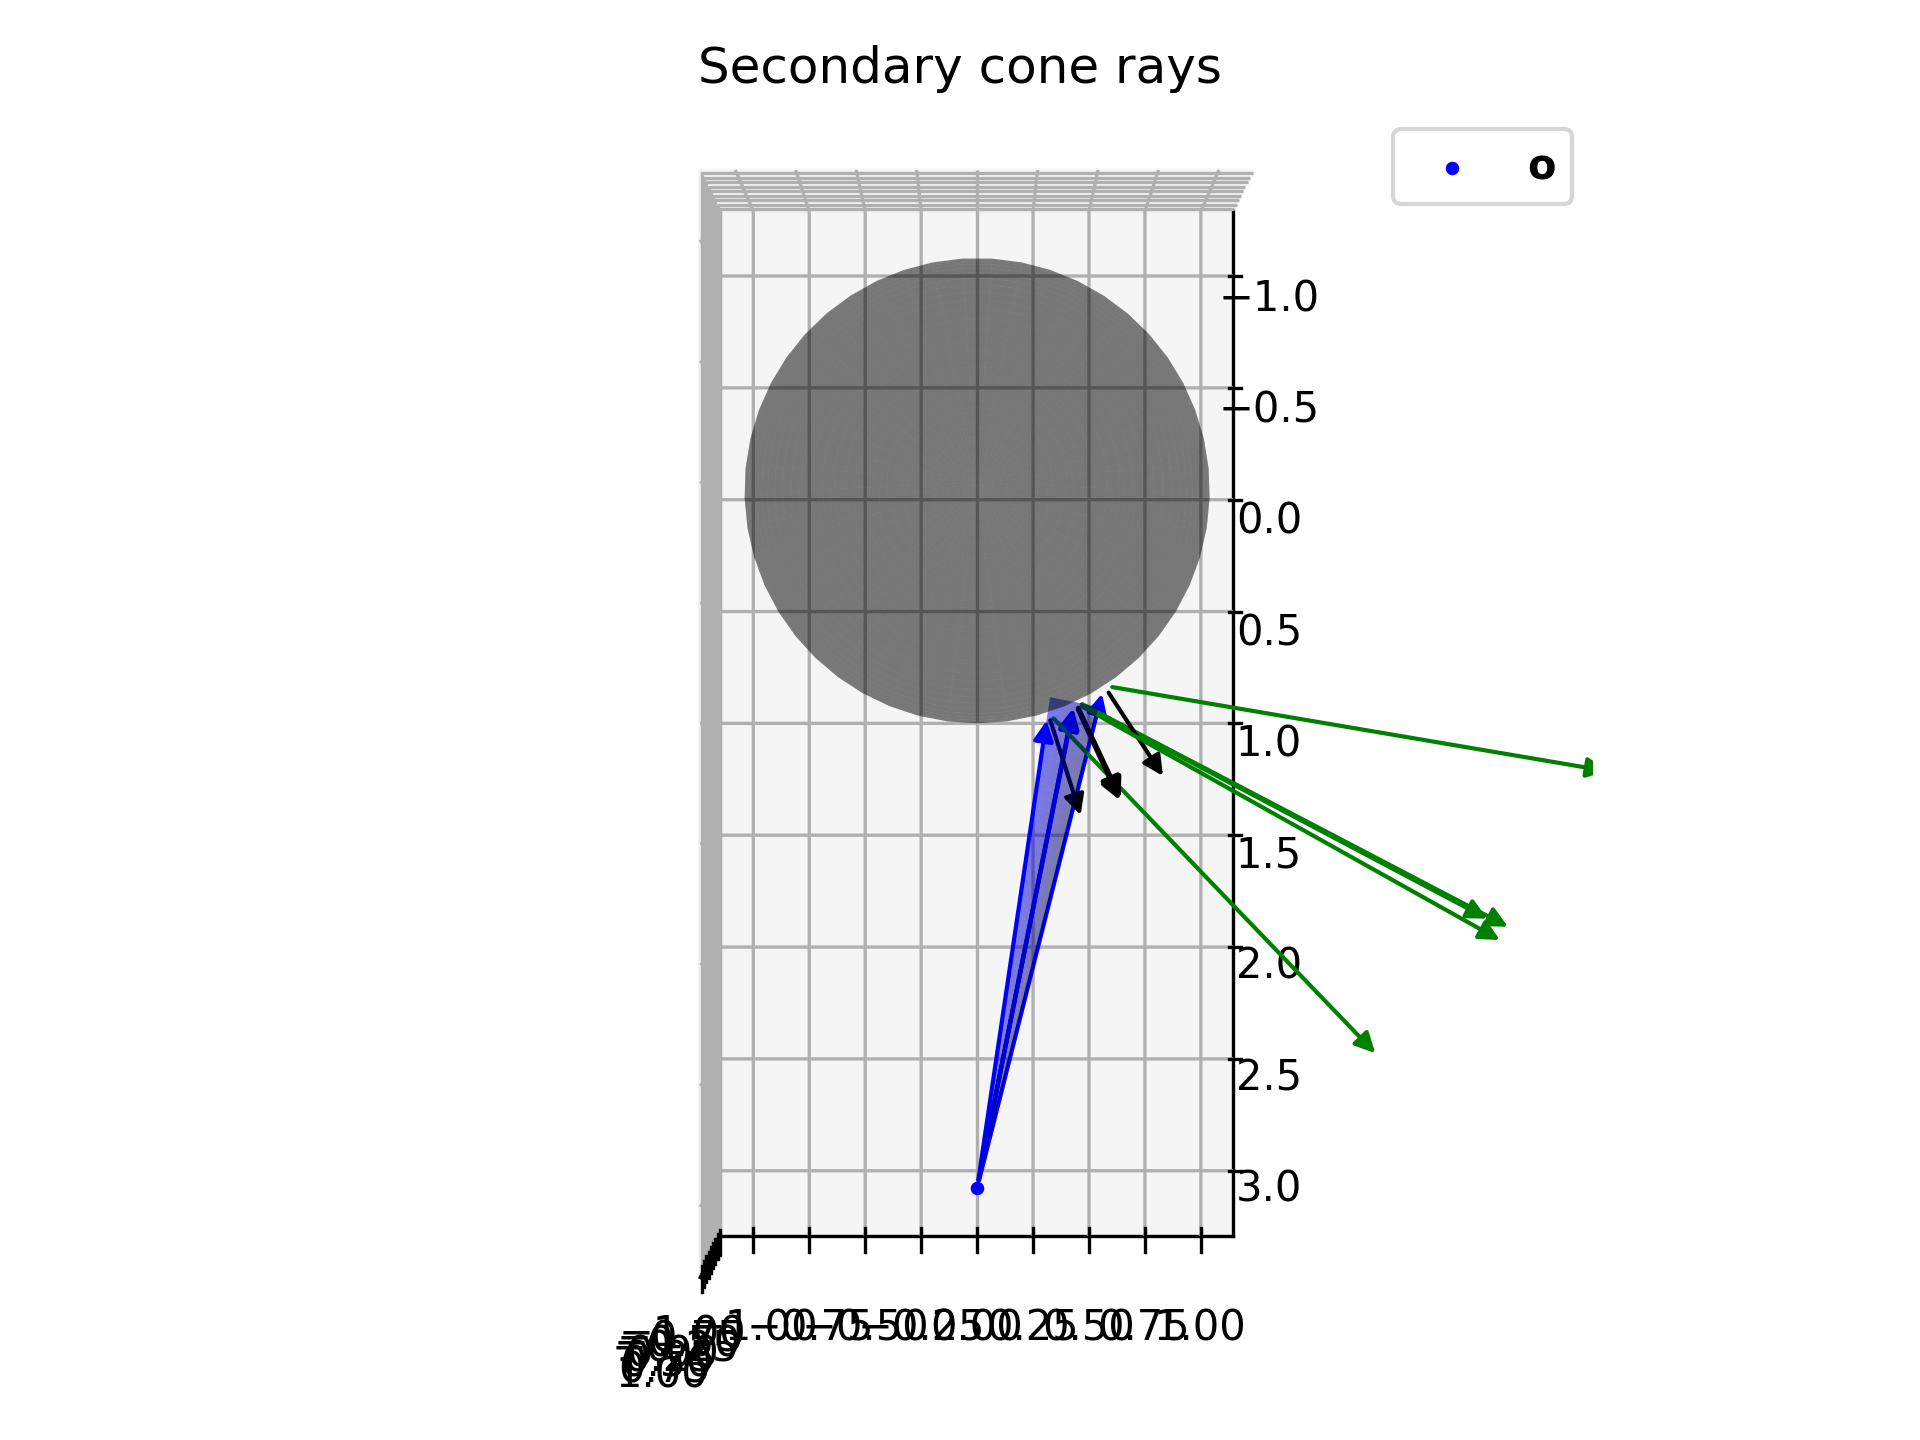

In [33]:
for cone_ray_idx in range(5):
    isnan = torch.isnan(t_int[:,:,cone_ray_idx]).sum()
    if isnan == 0:
    # plot3d_point(ax,to_np(p_int)[cone_ray_idx])
        plot3d_arrow(ax, to_np(p_int)[cone_ray_idx], 
                    to_np(t_int)[cone_ray_idx], 
                    to_np(d_r)[cone_ray_idx],
                    color='g', label='Reflected cone rays')
        plot3d_arrow(ax, to_np(p_int)[cone_ray_idx], 
                    to_np(0.5+0.*t_int)[cone_ray_idx], 
                    to_np(n_int)[cone_ray_idx],
                    color='k', label='Normals')
ax.azim=0
ax.elev = 90
plt.title("Secondary cone rays")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Virtual Cone params

**1. Virtual Cone Apex**

We approximate the cone apex as the point with least total distance from all the reflected cone rays. This can be posed as a pseudo-inverse problem as described [here](https://math.stackexchange.com/a/55286).

In [34]:
def closest_pt_to_lines(p_int, d_r):
    # Written in terminology described in the link
    w_i = p_int[...,None] # N x P x 5 x 3 x 1
    u_i = d_r[...,None] # N x P x 5 x 3 x 1
    I = torch.eye(3).to(p_int.device).float()
    # Add singleton based on batch dimensions of w_i
    I = I.reshape((1,)*(w_i.ndim-2)+I.shape) # N x P x 5 x 3 x 3
    A_i = I - u_i@transp(u_i) # N x P x 5 x 3 x 3
    p_i = A_i @ w_i # N x P x 5 x 3 x 1

    # nan_mask to exclude cone rays that do not intersect sphere
    # Sum along cone rays
    A = (A_i).nansum(-3, keepdim=True) # N x P x 1 x 3 x 3
    p = (p_i).nansum(-3, keepdim=True) # N x P x 1 x 3 x 1

    A_pinv = torch.linalg.pinv(A)
    o_prime = A_pinv@p # N x P x 1 x 3 x 1

    return o_prime[...,0] # N x P x 1 x 3 x 1

o_prime = closest_pt_to_lines(p_int, d_r)

**2. Virtual cone axis**

Get ray directions from $\mathbf{o}'$ to the intersection points $\mathbf{p_{int}}$, $\mathbf{d}_{ro}$.

In [35]:
d_ro = normalize(p_int-o_prime)
t_ro = norm(p_int-o_prime)

d_ro_center = d_ro[:,:,[4]]

**3. Virtual Cone Radius**

Similar computation as mipNeRF.  We can use mipNeRF radius computation with camera origin as $\mathbf{o}'$, directions of center pixel $\mathbf{d}_{ro}[3]$ and directions of left,top,right and pixels as $0,1,2,3$ index of $\mathbf{d}_{ro}$

In [36]:
r_prime = norm(d_ro[:,:,:4]-d_ro_center).nansum(2,keepdim=True)\
          /(~nan_mask[:,:,:4]).sum(2,keepdim=True)

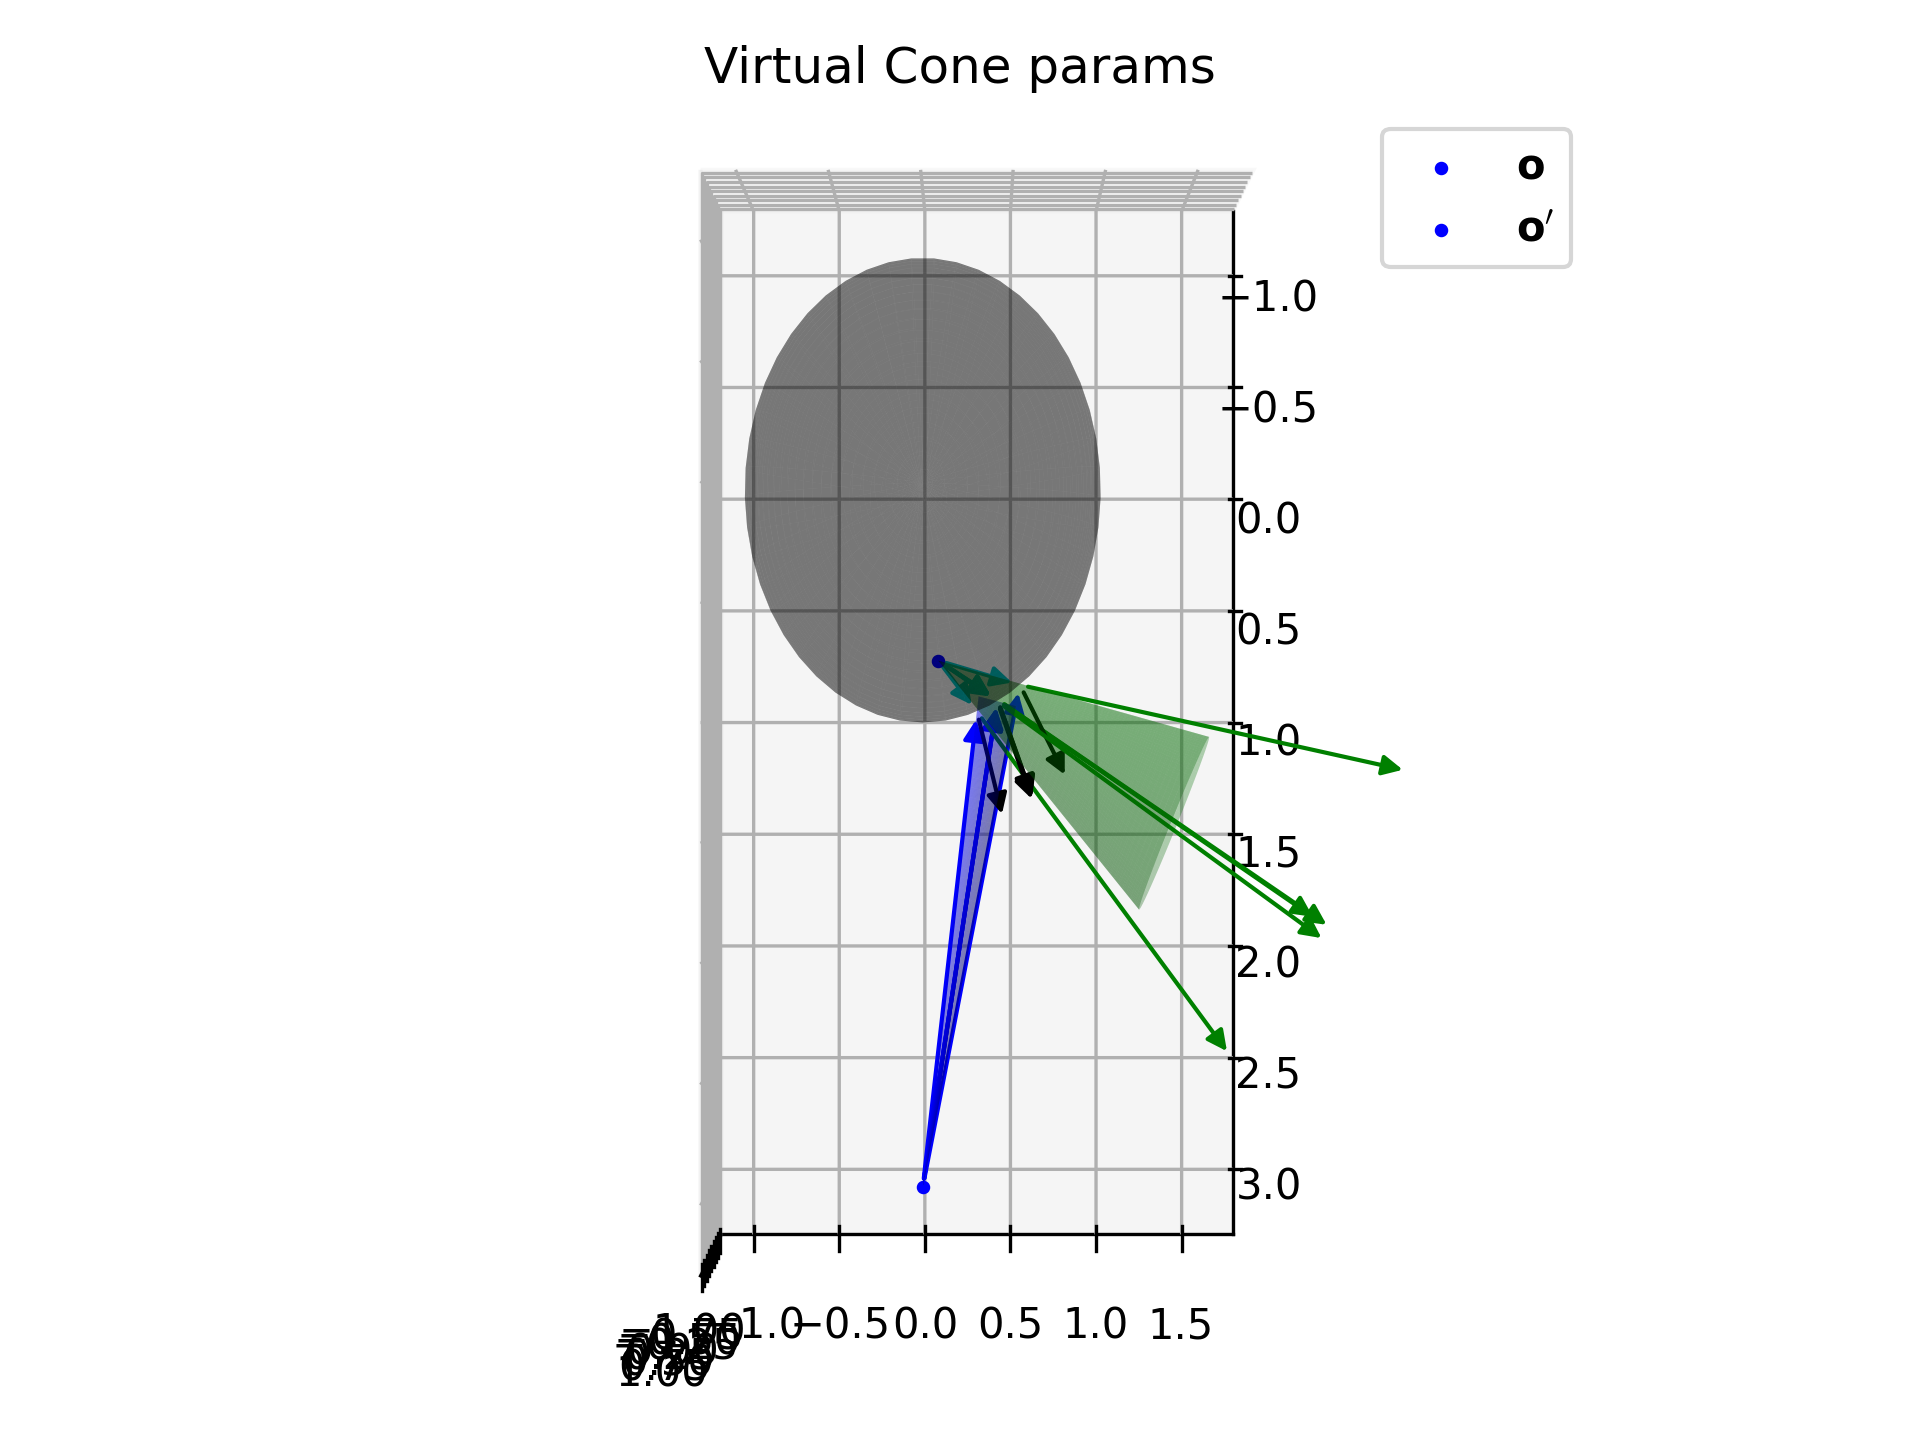

In [37]:
plot3d_point(ax,to_np(o_prime)[0],label='$\mathbf{o}\'$')
for cone_ray_idx in range(5):
    isnan = torch.isnan(t_int[:,:,cone_ray_idx]).sum()
    if isnan == 0:
        # plot3d_point(ax,to_np(p_int)[cone_ray_idx])
        plot3d_arrow(ax, to_np(o_prime)[0], 
                     to_np(t_ro)[cone_ray_idx], 
                     to_np(d_ro)[cone_ray_idx],
                     color='c', label='Approx. Reflected cone rays')
plot3d_cone(ax,to_np(o_prime)[0], 4*to_np(t_ro)[-1], 
            to_np(d_ro)[-1],to_np(r_prime)[0],
            color='g')
ax.azim=0
ax.elev = 90
plt.title("Virtual Cone params")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Putting it all together
Combined function to go from given quantities to virtual cone parameters

In [38]:
def get_virtual_cone_params_sphere(o,d,r,up,t,n,R):
    # Add singleton dimensions to given quantities for cone rays
    add_sing = lambda x: x[:,:,None,:]
    o_s  = add_sing(o) # NxP x1x3
    d_s  = add_sing(d) # NxP x1x3
    r_s  = add_sing(r) # NxP x1x3
    up_s = add_sing(up) # NxP x1x3
    t_s = add_sing(t) # NxP x1x3
    n_s = add_sing(n) # NxP x 1 x3
    R_s = add_sing(R) # NxP x1x3
    
    ########### Compute primary cone rays
    d_cone,t_cone = get_primary_cone_rays(o_s,t_s,d_s,r_s,up_s)
    # Intersection of primary cone rays and oscullating sphere
    p_s = o_s + t_s*d_s
    #Find the center of osculating sphere by backtracing surface normal till R
    c_est = p_s - R_s*n_s
    # append primary ray point to cone rays
    p_int = intersect_ray_sphere(o_s,d_cone,c_est,R_s)
    t_int = norm(p_int-o_s)
    # nan_mask corresponding to rays that do not intersect
    nan_mask = torch.isnan(t_int)

    p_int = torch.cat([p_int, p_s],-2)
    t_int = torch.cat([t_int,t_s],-2)
    d_cone = torch.cat([d_cone, d_s],-2)
    # Primary intersection is always valid
    nan_mask = torch.cat([nan_mask, 
                          torch.zeros_like(nan_mask[:,:,[0]])],-2)

    ########## Compute reflected cone rays
    n_int = normalize(p_int-c_est)
    d_r = d_cone - 2*dot(d_cone, n_int)*n_int

    
    ######### Compute Cone params
    # 1. Virtual cone apex
    o_prime = closest_pt_to_lines(p_int, d_r)
    # 2. Virtual cone axis
    d_ro = normalize(p_int-o_prime)
    t_ro = norm(p_int-o_prime)
    d_ro_center = d_ro[:,:,[4]]
    # 3. Virtual cone radius
    r_prime = norm(d_ro[:,:,:4]-d_ro_center).nansum(2,keepdim=True)/\
                (~nan_mask[:,:,:4]).sum(2,keepdim=True)

    # Remove singleton dimensions for cone rays
    rem_sing = lambda x: x[:,:,0]
    o_prime_r = rem_sing(o_prime)
    d_ro_center = rem_sing(d_ro)
    r_prime_r = rem_sing(r_prime)

    return o_prime_r, d_ro_center, r_prime_r


In [39]:
o_prime, d_prime, r_prime = get_virtual_cone_params_sphere(o,d,r,up,t,n,R)

Visualize only input and output variables

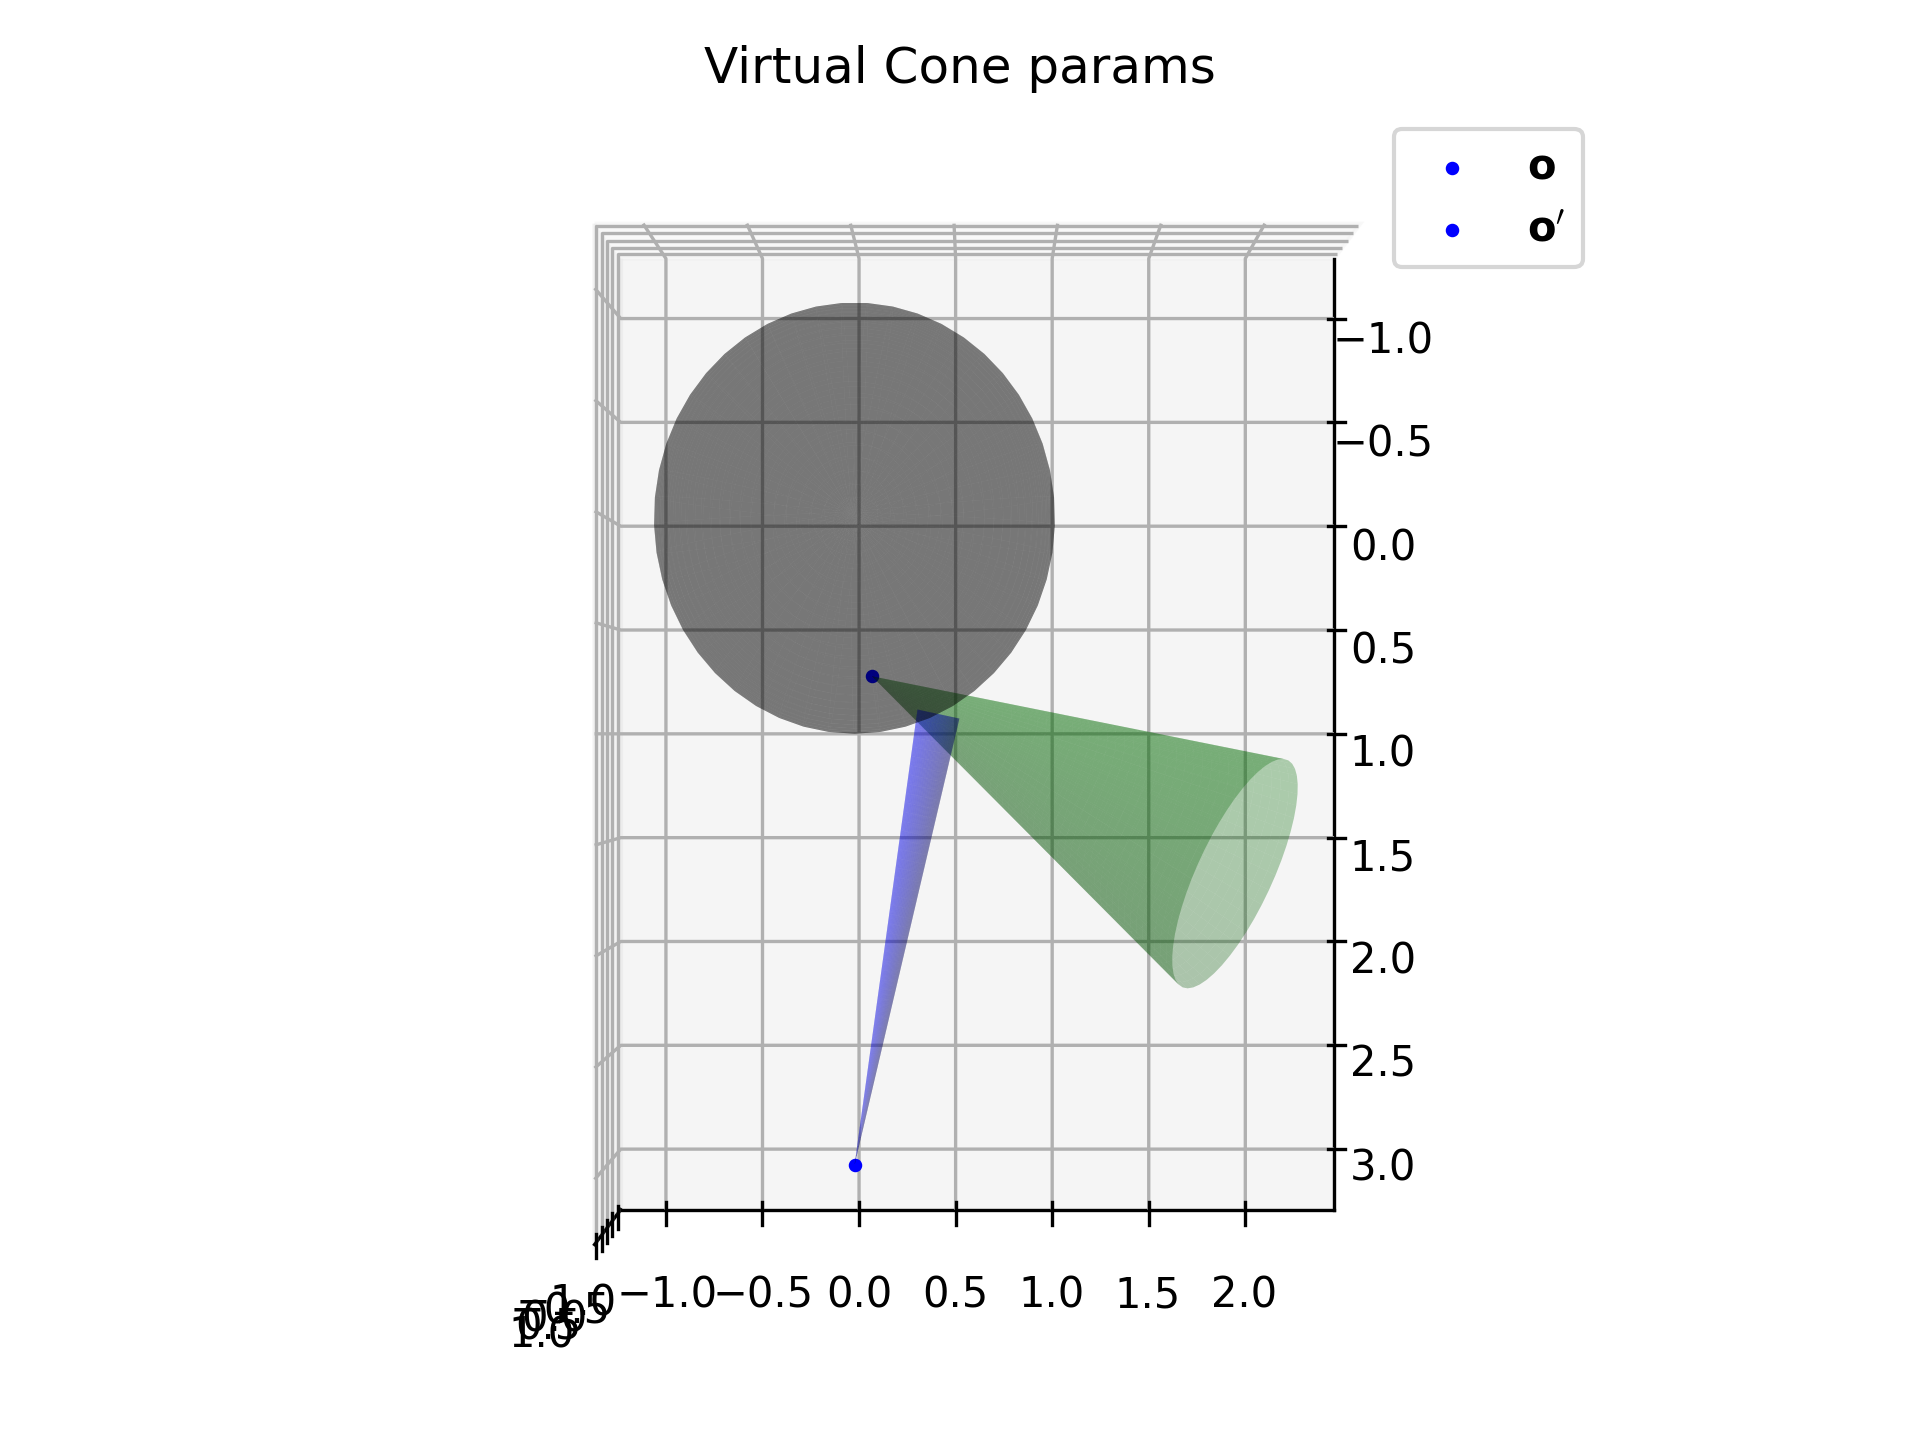

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((4,3,2))

# Input
plot3d_sphere(ax, to_np(R), to_np(c))
plot3d_point(ax, to_np(o), label='$\mathbf{o}$')
plot3d_cone(ax, to_np(o), to_np(t), to_np(d), to_np(r))

# Output
plot3d_point(ax,to_np(o_prime),label='$\mathbf{o}\'$')
plot3d_cone(ax,to_np(o_prime), to_np(t), 
            to_np(d_prime),to_np(r_prime),
            color='g')

ax.azim=0
ax.elev = 90
plt.title("Virtual Cone params")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()